# Diagnostics: Bias vs. Variance

In [3]:
# import key libraries (remember to pip install numpy etc. first)
import numpy as np
import sys
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline

## Part 1: Loading and Visualizing Data

In [4]:
# Load Training Data
print('Loading and Visualizing Data ...')

# import csv data
PATH="./data/"
DATA="ex5data1.mat"

import scipy.io
mat = scipy.io.loadmat(f'{PATH}{DATA}') # training data stored in arrays X, y
X = mat['X']
y = mat['y']
Xtest = mat['Xtest']
Xval = mat['Xval']
ytest = mat['ytest']
yval = mat['yval']

Loading and Visualizing Data ...


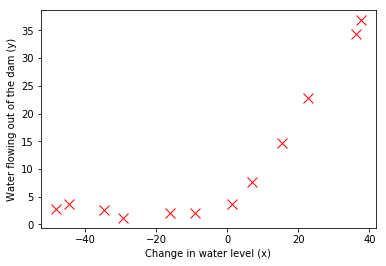

In [5]:
# m = Number of examples
m = X.shape[0]

# Plot training data
plt.plot(X, y, 'rx', markersize=10, linewidth=1.5);
plt.xlabel('Change in water level (x)');
plt.ylabel('Water flowing out of the dam (y)');

plt.show()

## Part 2: Regularized Linear Regression Cost

In [ ]:
theta = [1 ; 1];
J = linearRegCostFunction([ones(m, 1) X], y, theta, 1);

fprintf(['Cost at theta = [1 ; 1]: %f '...
         '\n(this value should be about 303.993192)\n'], J);

fprintf('Program paused. Press enter to continue.\n');
pause;